## Ploting results from feature compression datasets

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### BLAT Ostermeier 2014

In [ ]:
# Once we have all the fasta files and metadata we can extract the embeddings for each fasta.
python scripts/extract.py esm2_t30_150M_UR50D data/sumo1_human_data.fasta embeddings/sumo1_esm2_150M --repr_layers 30 --include bos mean per_tok


# Then we can compress the embeddings with the following command
dir_path = 'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M/'
for i in ['mean', 'bos', 'max_pool', 'pca1', 'pca2', 'pca1-2', 'iDCT', 'rbf1', 'sigmoid1']:
    print(f'Compressing embeddings using {i}')
    embed = load_per_tok_embeds(dir_path, i)
    with open(f'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed/BLAT_ECOLX_Ostermeier2014_esm2_150M_{i}.pkl', 'wb') as f:
        pickle.dump(embed, f)


# or one by one, but will take too long
python scripts/compressing_embeddings_v02.py  -e embeddings/sumo1_esm2_150M -c mean -l 30


# or by using the following command, see the script for more details
bash run_compression.sh


# with the compressed embedding we can run the regression model, see script for more details
python scripts/run_reg_Lasso.py -i embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed -m data/BLAT_ECOLX_Ostermeier2014_metadata_v02.csv -o results/BLAT_ECOLX_Ostermeier2014_esm2_150M_layer_30_compressed.csv

In [ ]:
# checking corrupted files
path_compressed_embeds = 'embeddings/PABP_YEAST_Fields2013_doubles_esm2_150M_compressed'
for file in os.listdir(path_compressed_embeds):
    if file.endswith('.pkl'):
        method = file.split('_')[-1].split('.')[0]
        print('\nResults for method:', method)
        file_path = os.path.join(path_compressed_embeds, file)
        embed = pd.read_pickle(file_path)
        embed_df = pd.DataFrame.from_dict(embed, orient='index').reset_index()
        embed_df.rename(columns={'index': 'ID'}, inplace=True)

## Results

In [2]:
def plot_results(res_path):
    results = pd.read_csv(res_path, index_col=0)
    results.sort_values('Compression_methd', inplace=True)
    title = ' '.join(res_path.split('/')[-1].split('_')[:-5])
    plt.figure(figsize=(12, 5))
    sns.barplot(data=results, x='Compression_methd', y='R2_score_test')
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel('R2 Score')
    plt.xlabel('Compression methd')
    plt.show()

1


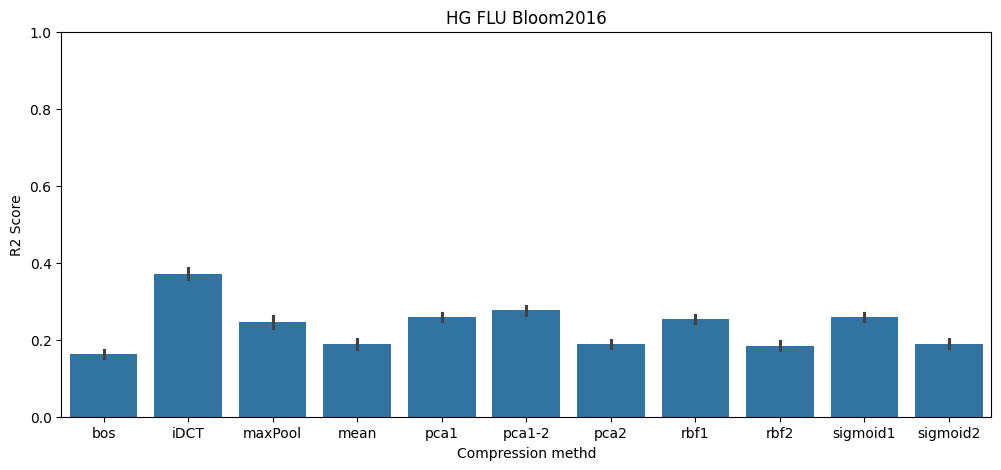

2


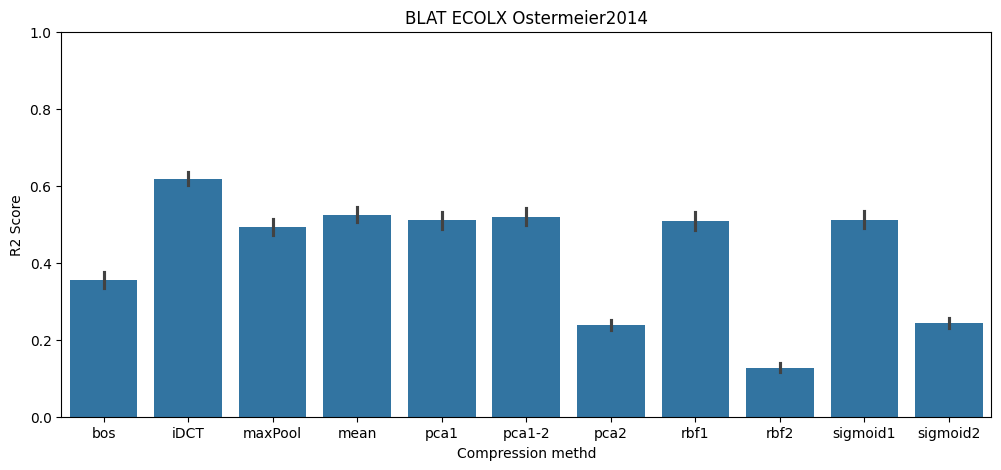

3


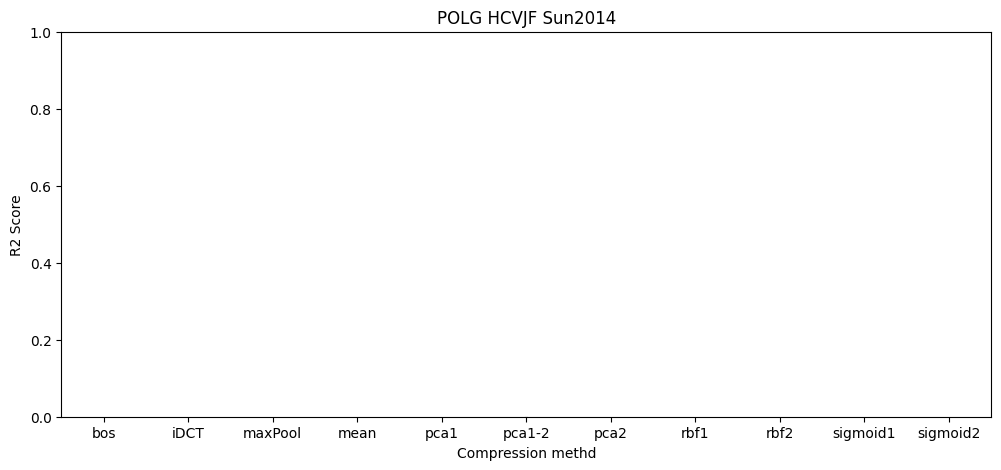

4


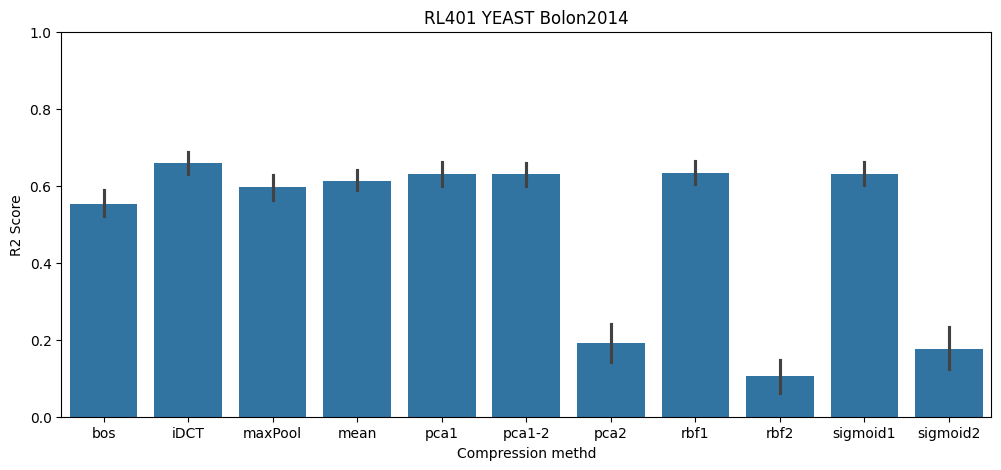

5


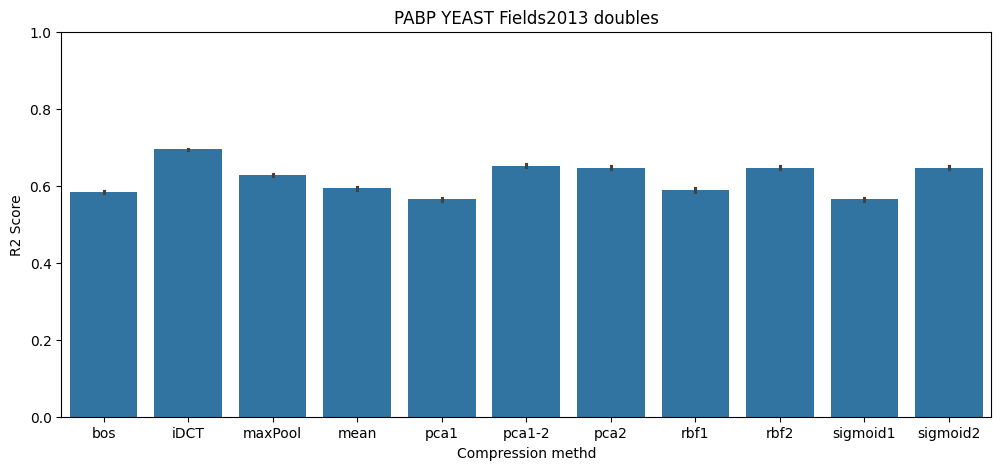

6


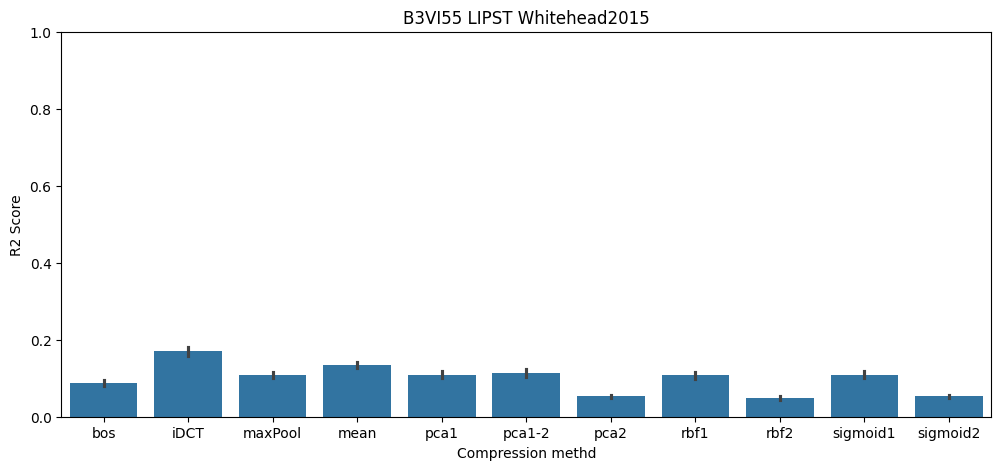

7


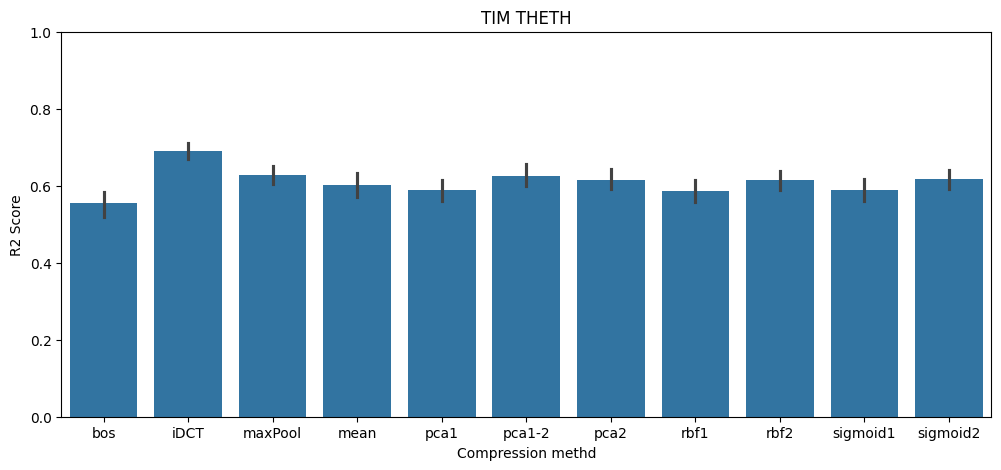

8


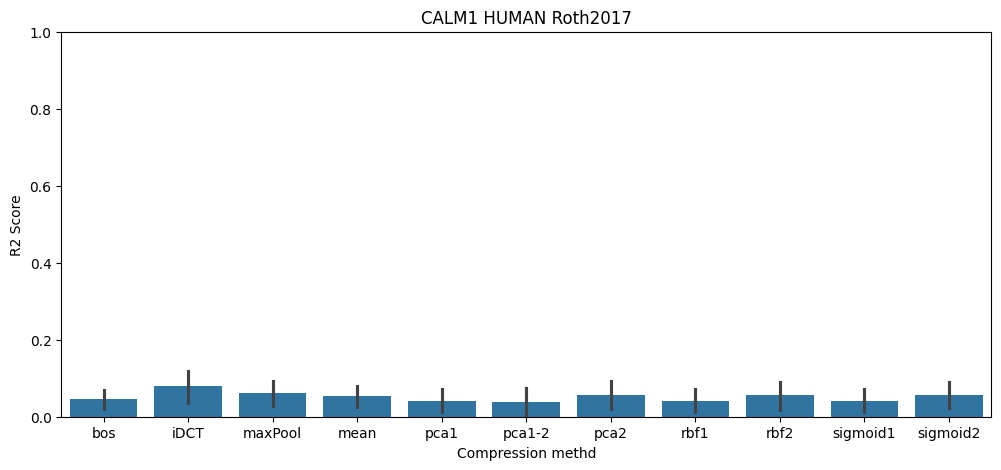

9


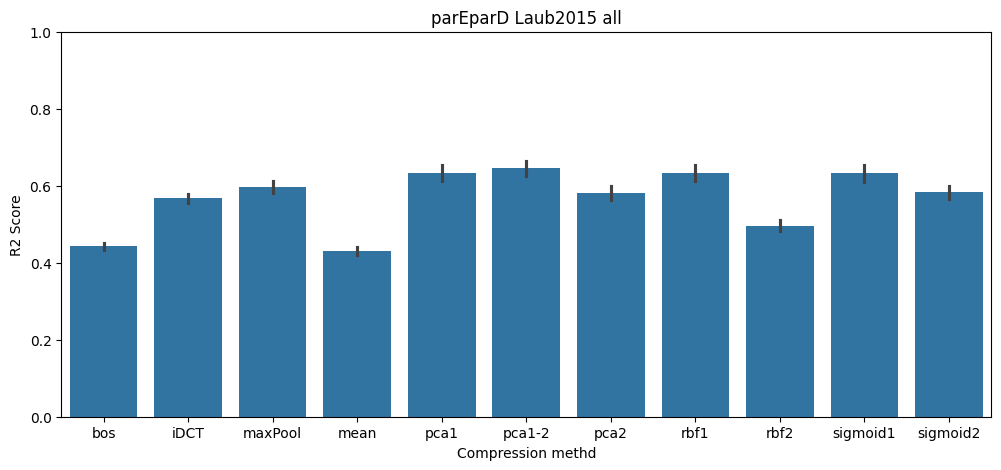

10


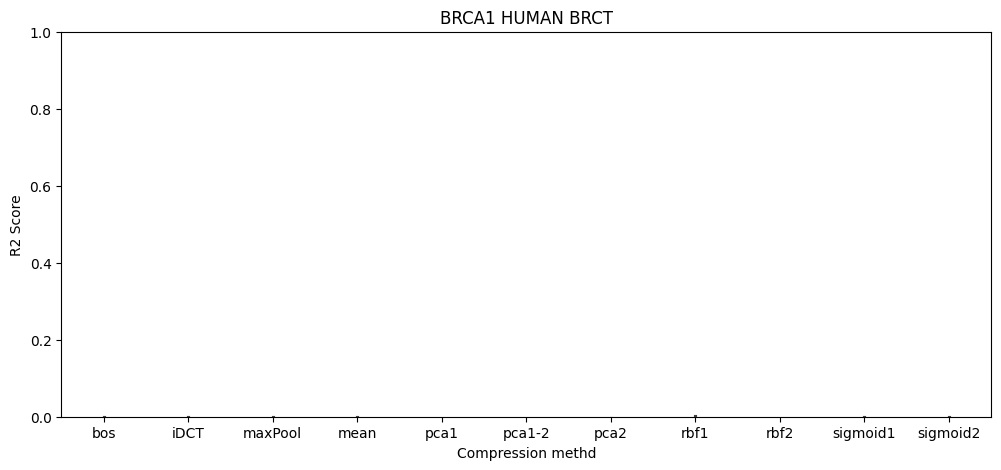

11


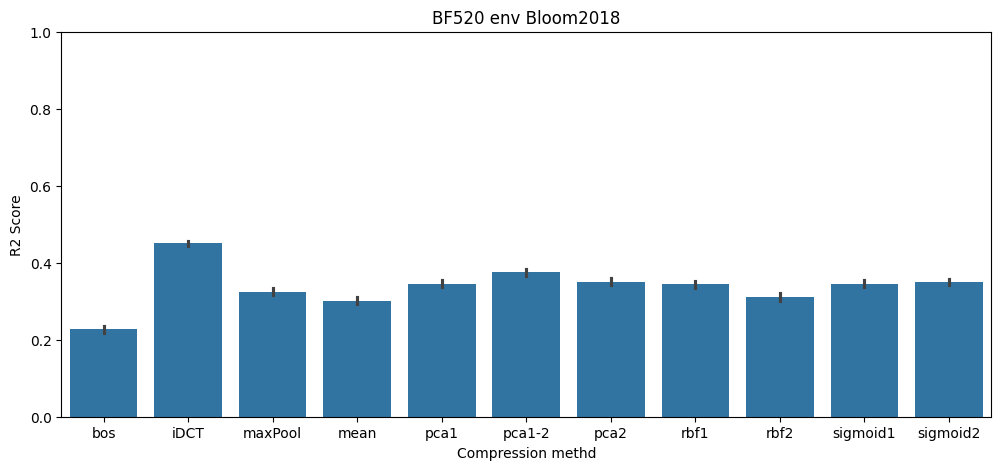

12


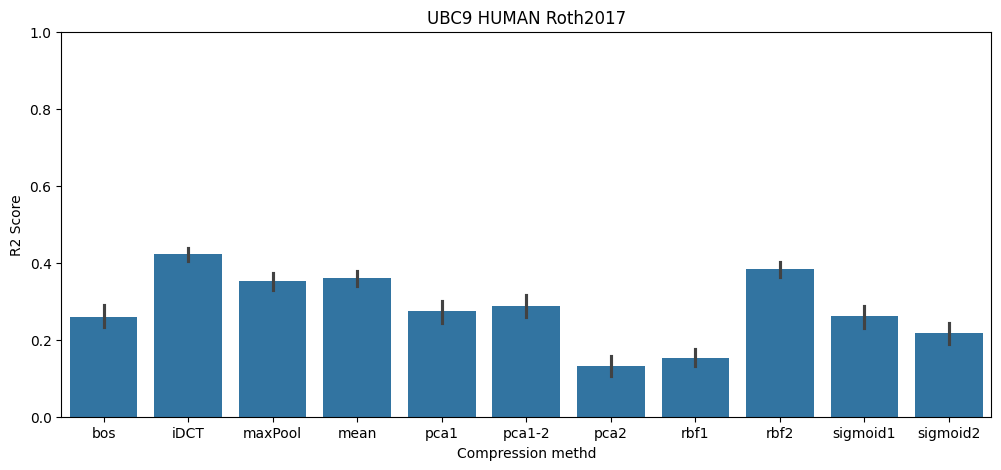

13


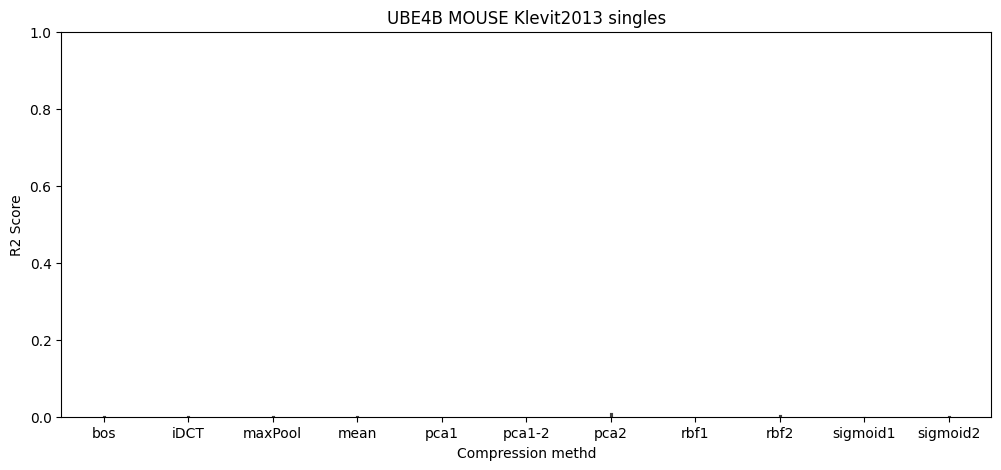

14


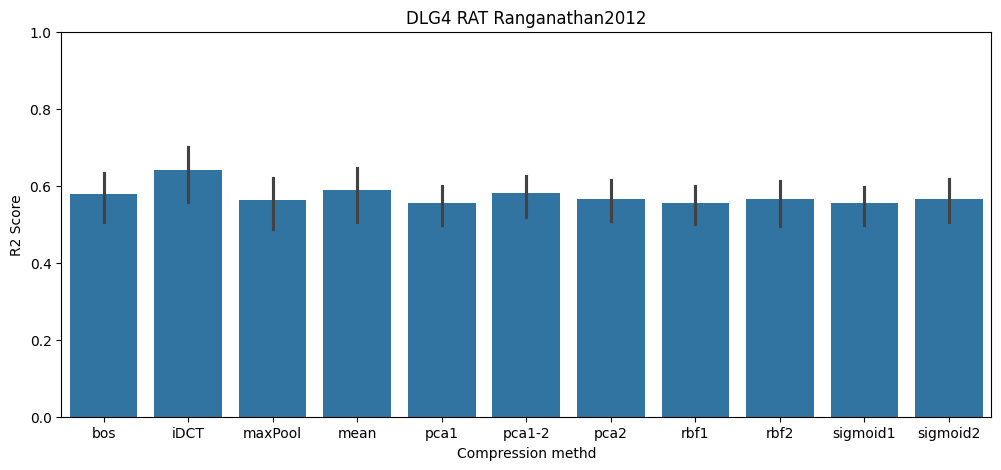

15


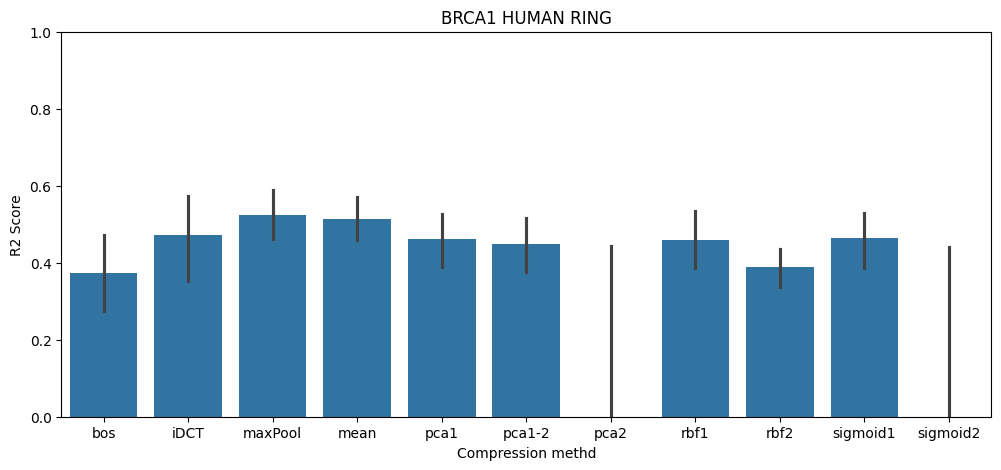

16


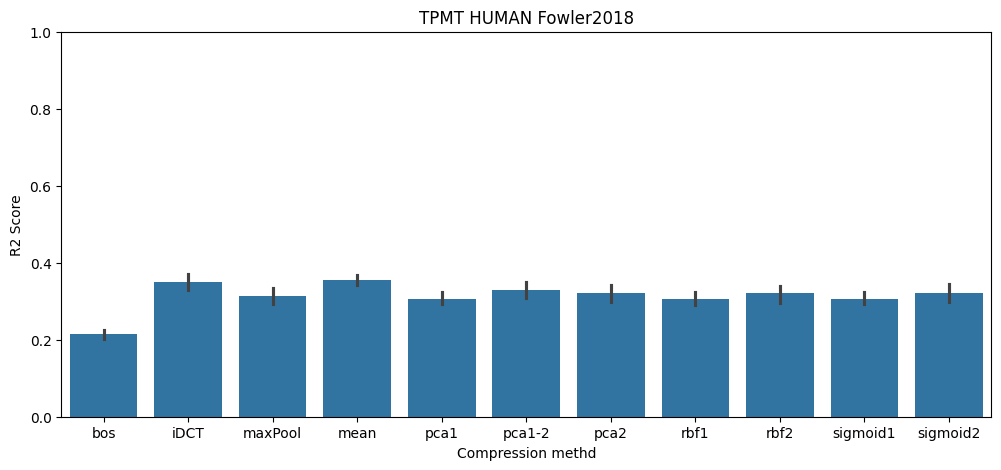

17


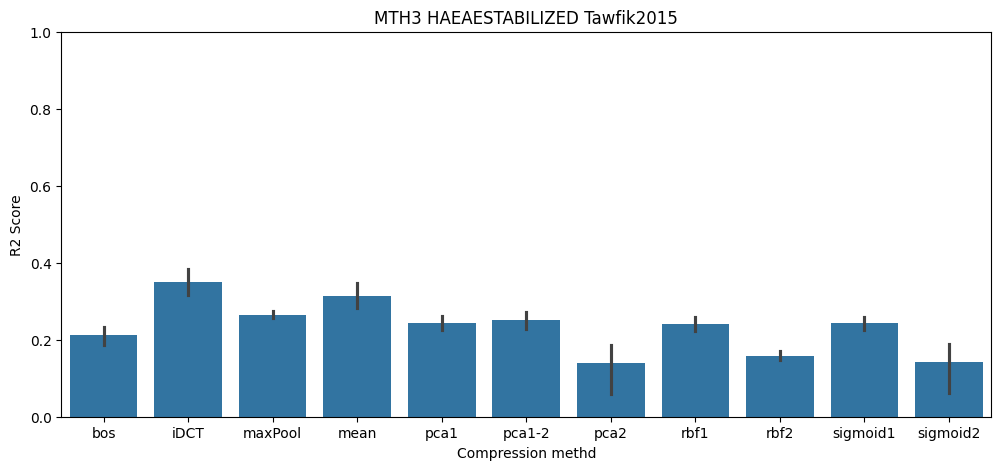

18


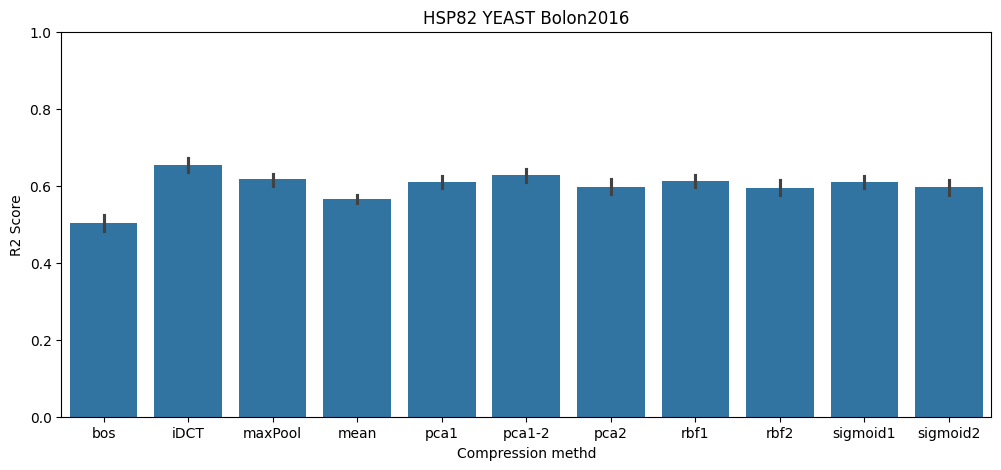

19


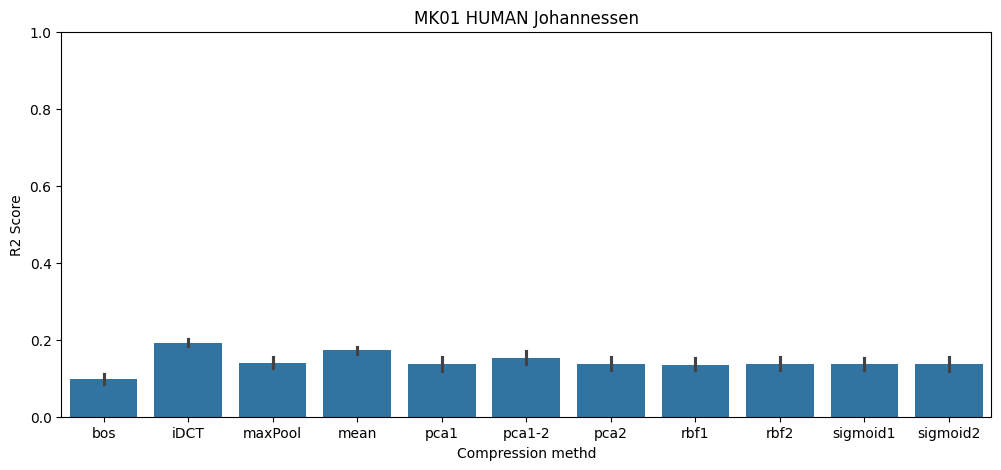

20


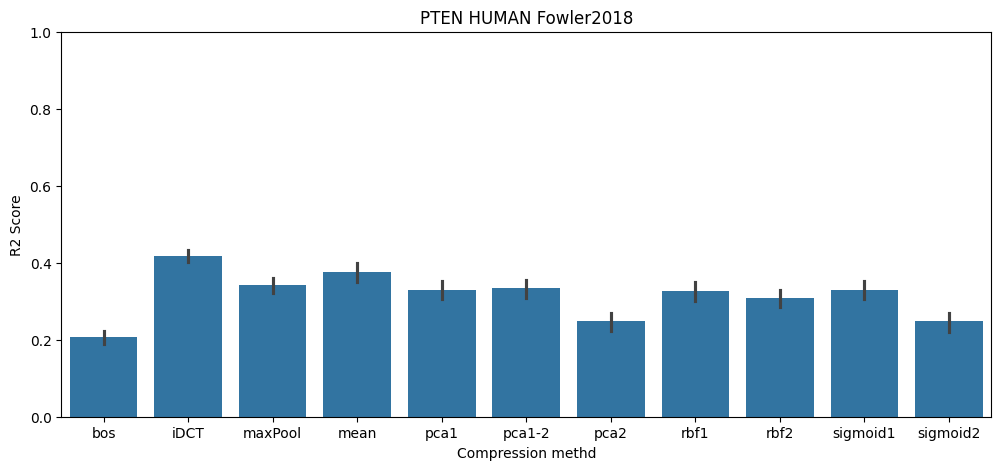

21


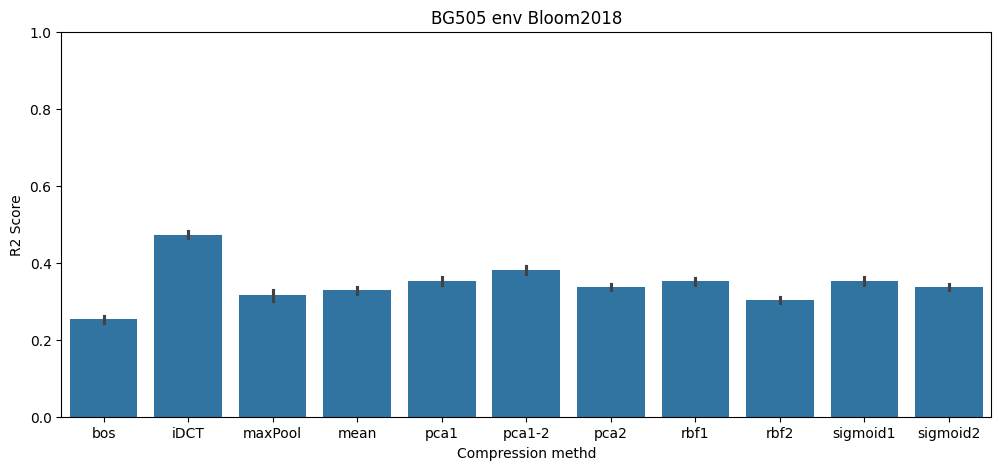

22


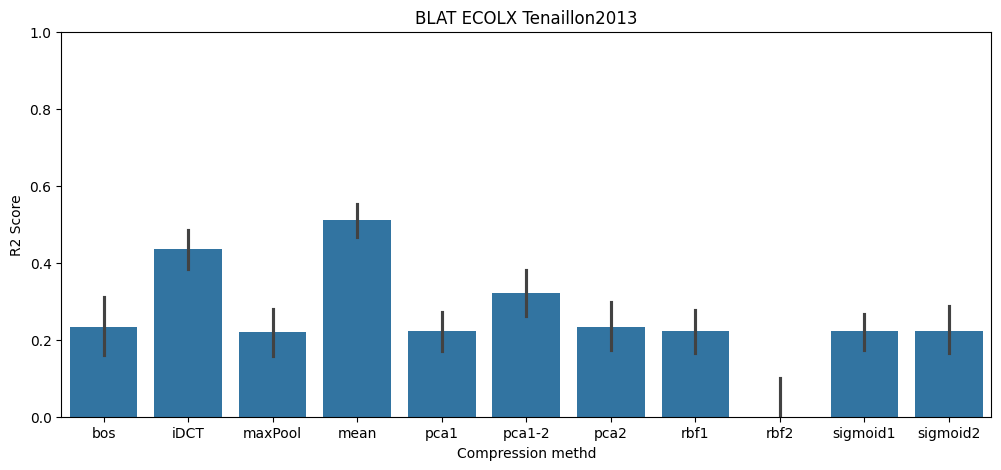

23


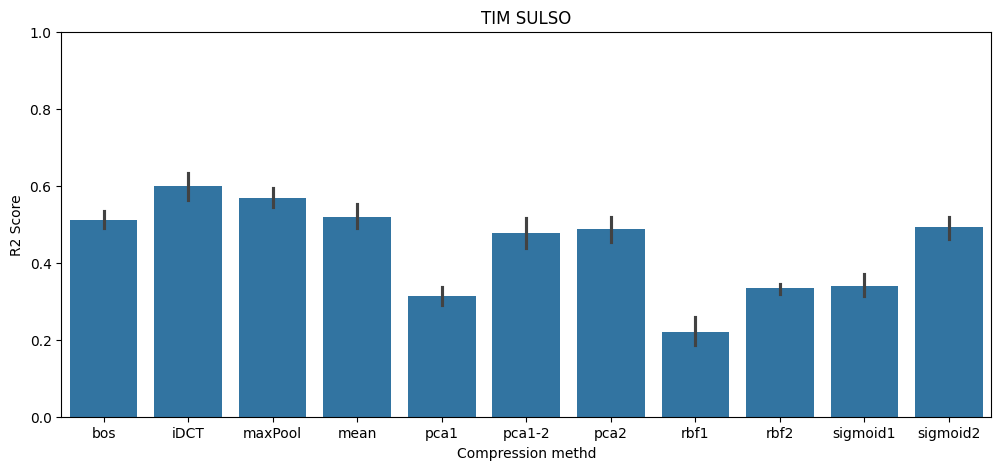

24


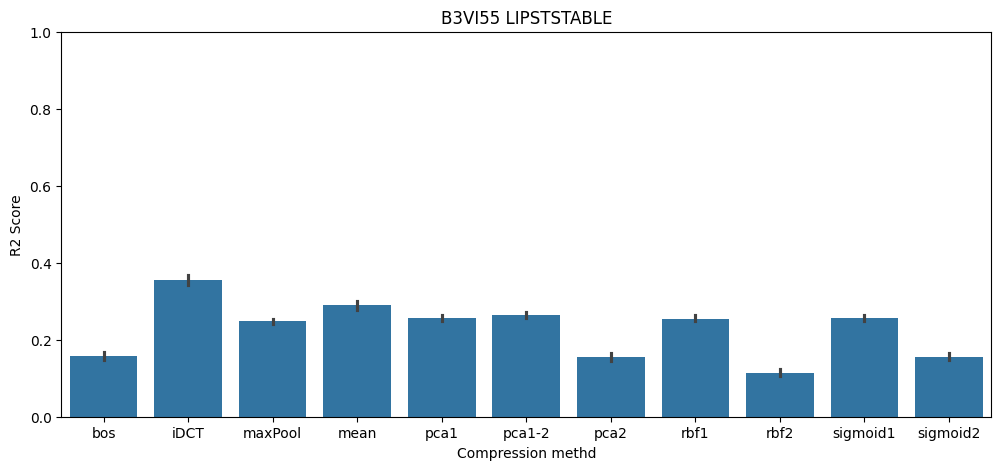

25


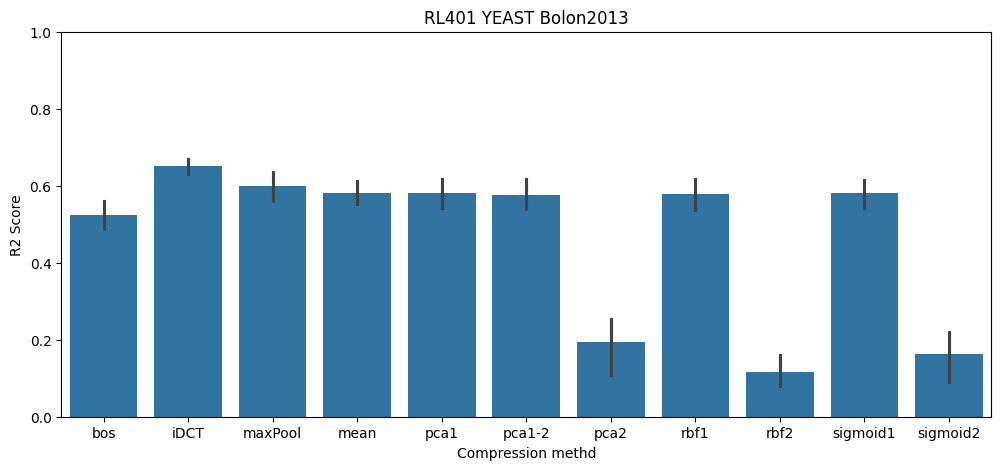

26


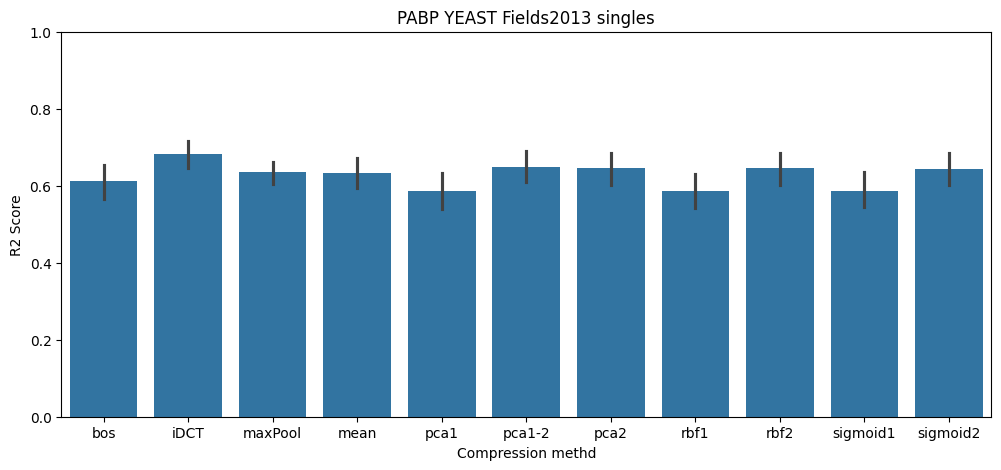

27


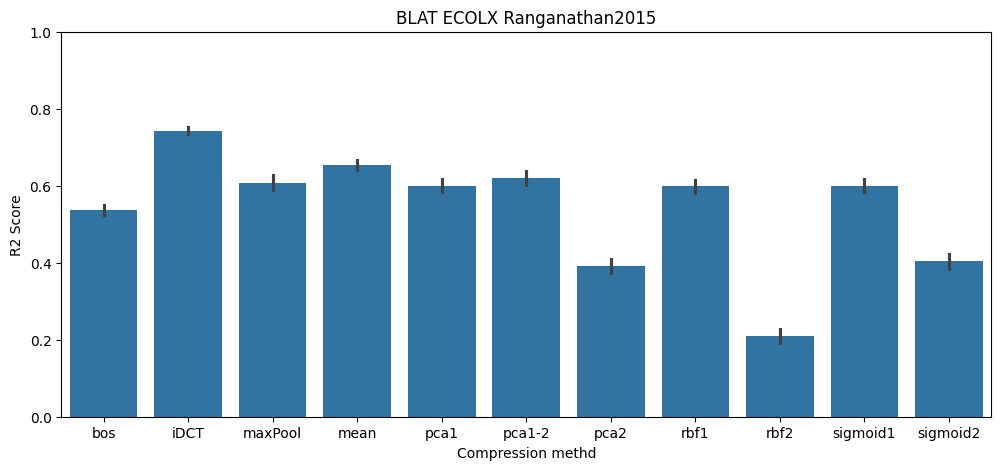

28


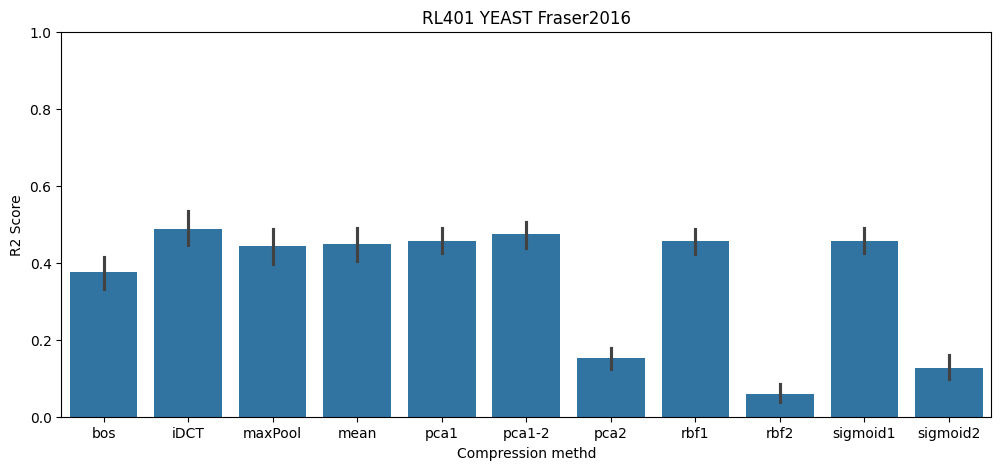

29


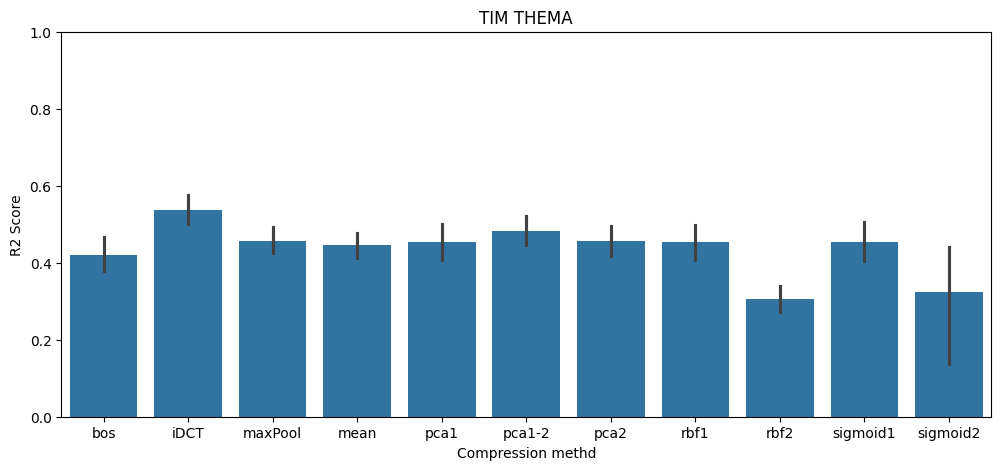

30


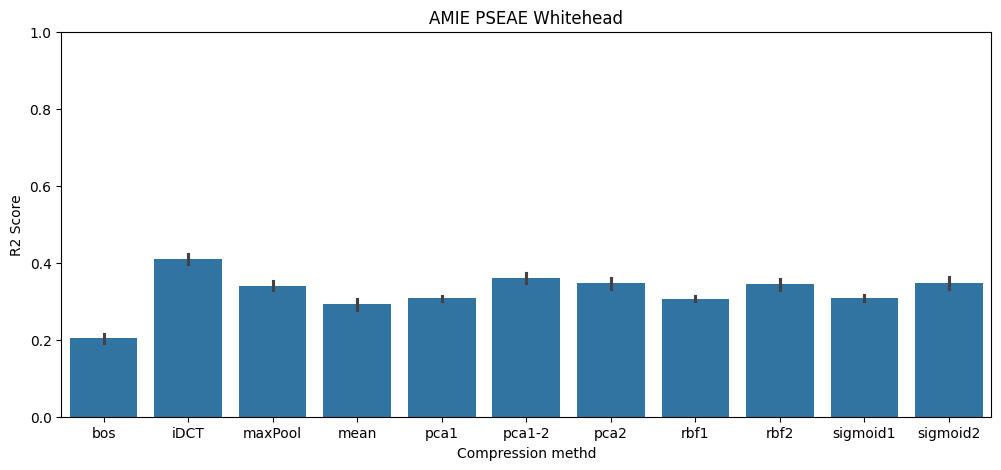

31


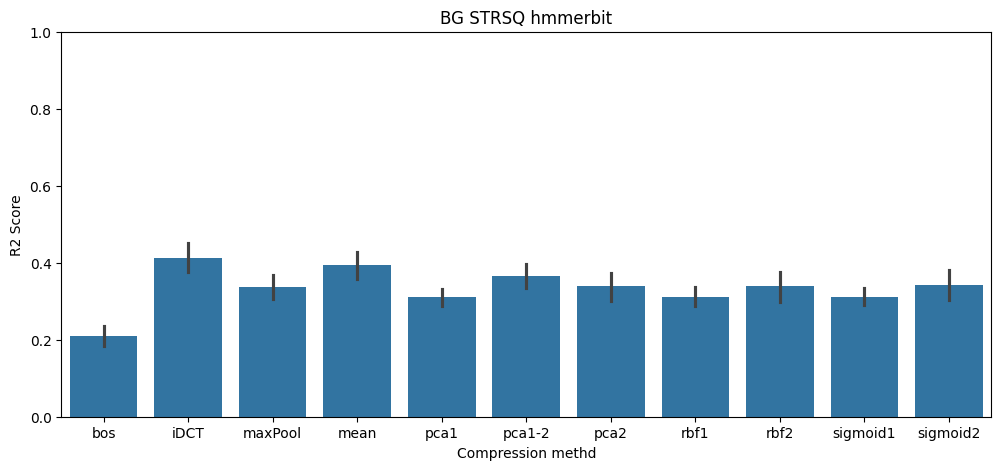

32


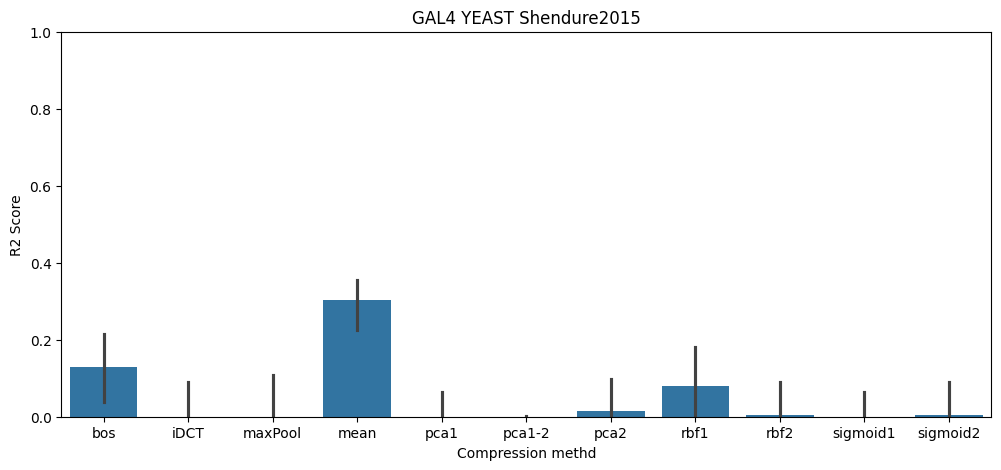

33


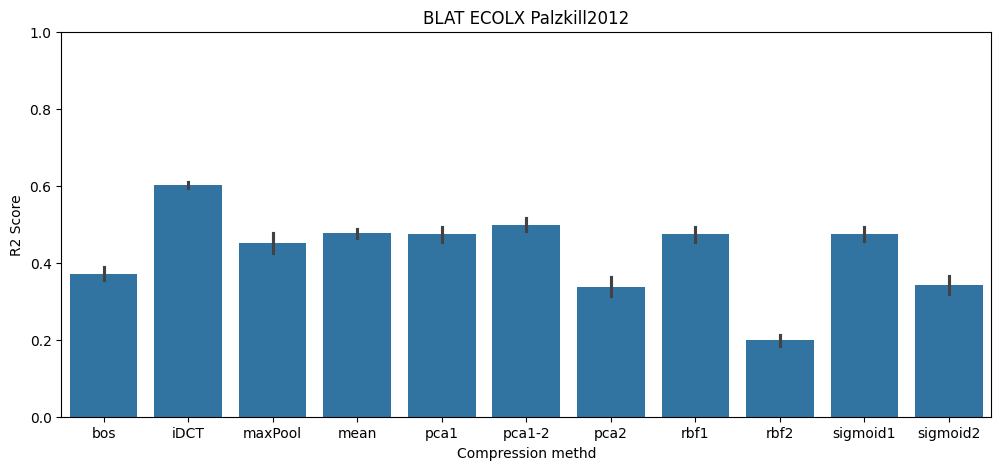

34


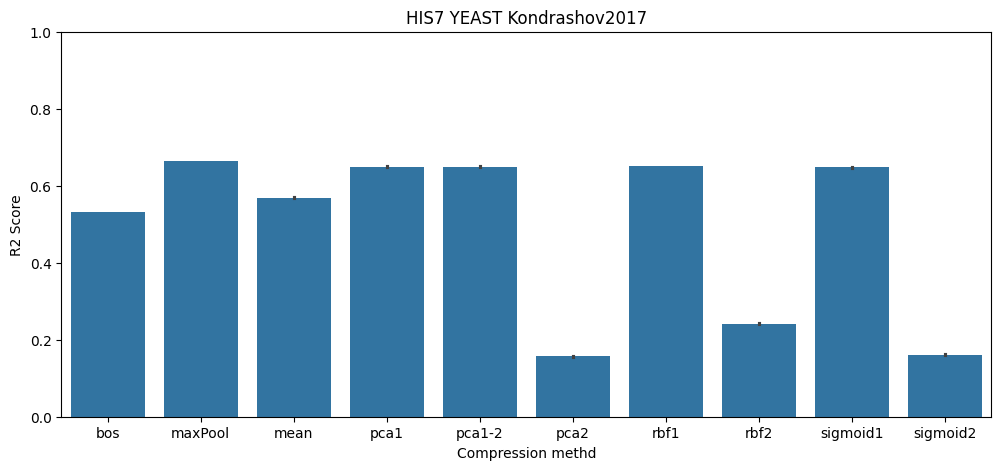

35


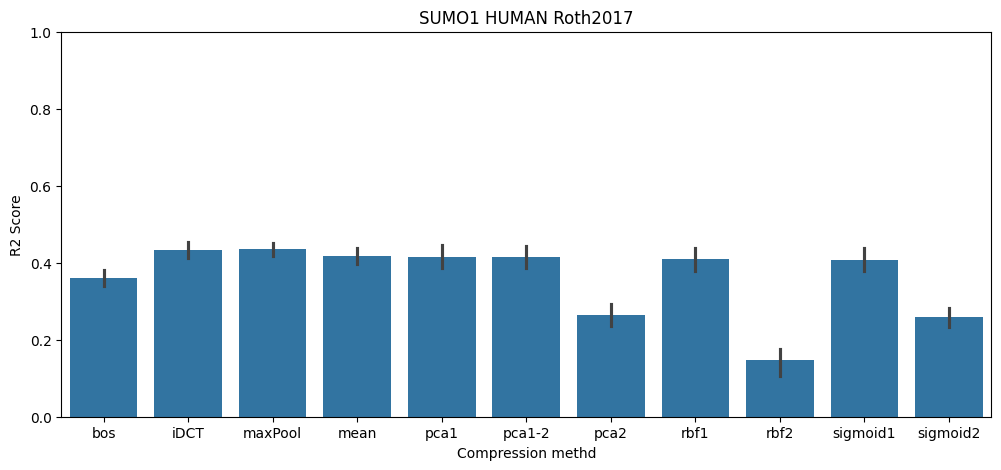

36


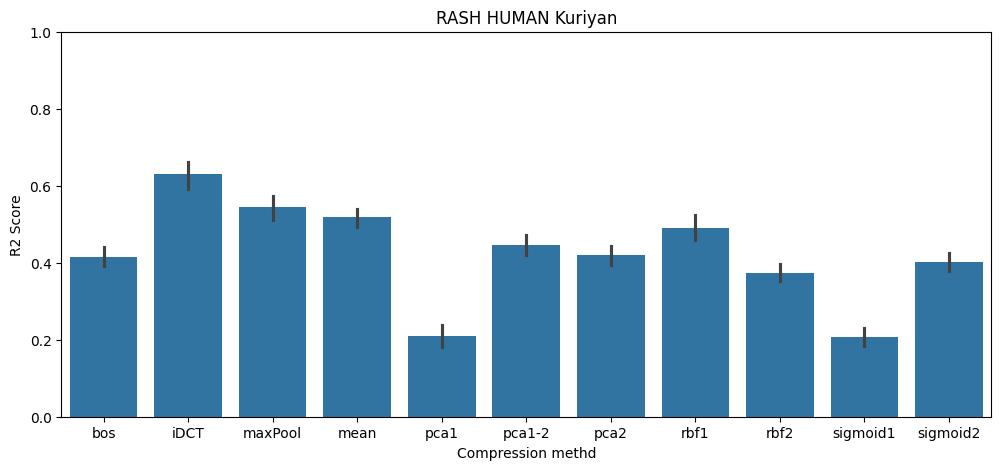

37


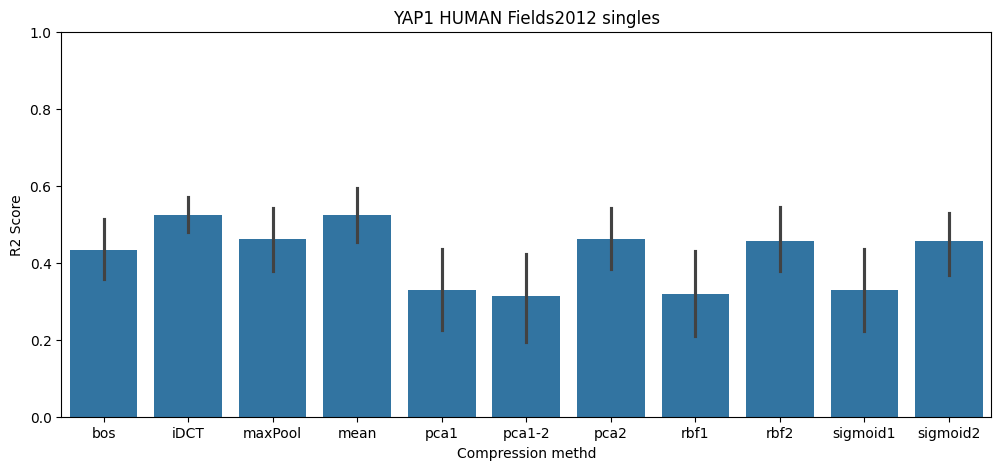

38


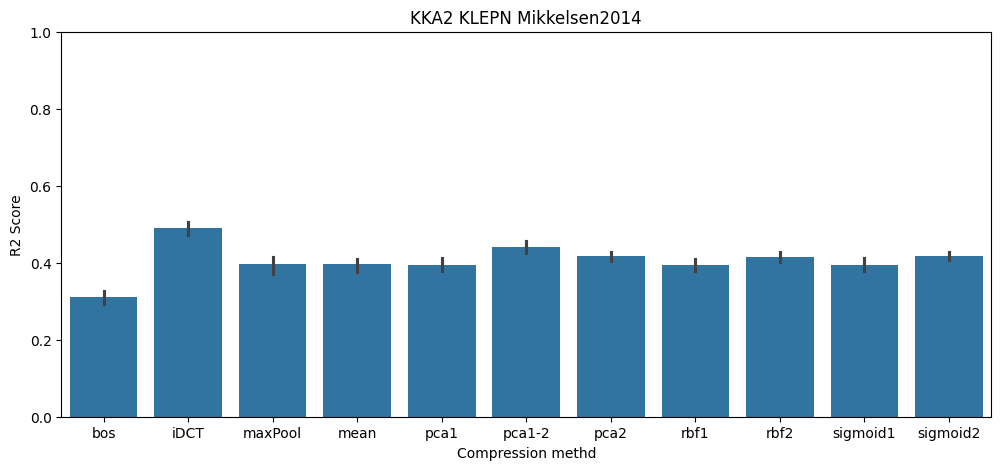

39


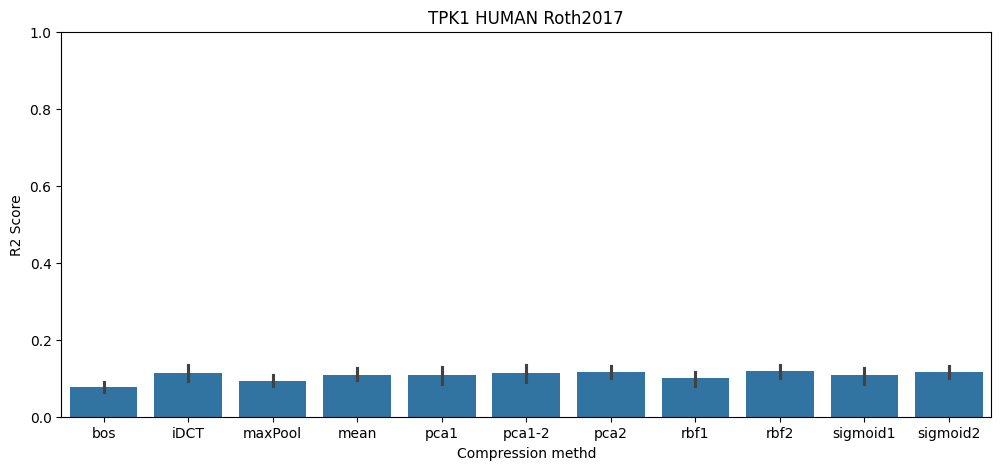

40


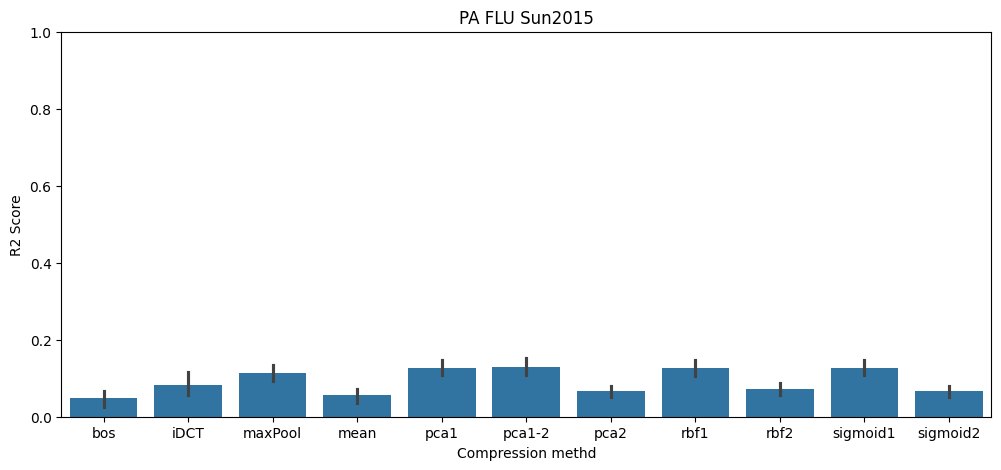

41


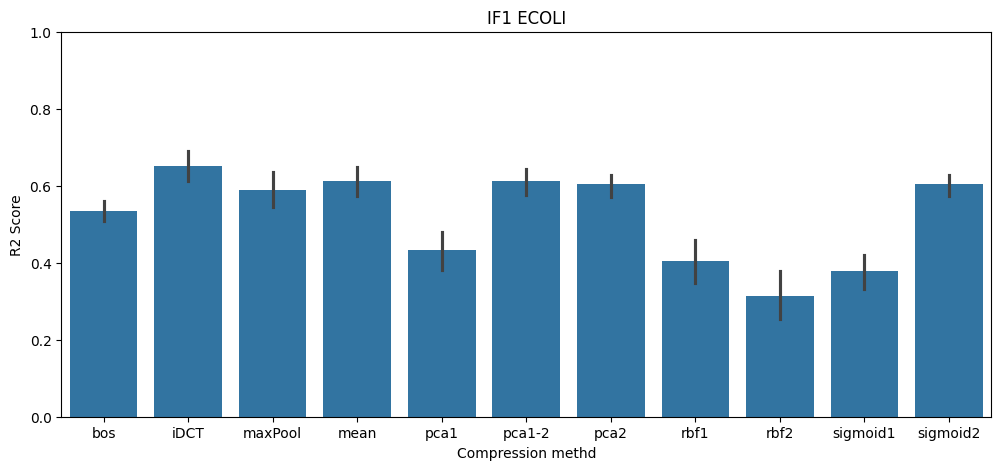

In [3]:
count=0
for file in os.listdir('results/regression/'):
    count+=1
    print(count)
    file_path = os.path.join('results/regression/', file)

    plot_results(file_path)